In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import datetime
from datetime import date
import pandas as pd
import time 
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import sys
import logging
# import helper
import laboneq.pulse_sheet_viewer.pulse_sheet_viewer as psv

In [2]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# a new *notably different* res_spec_calib function
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
   exp_calibration = Calibration()
   # sets the oscillator of the experimental measure signal
   my_osc = Oscillator(
           "readout_osc",
           frequency=frequency_sweep,
           modulation_type=ModulationType.HARDWARE,
   )
   exp_calibration["measure"] = SignalCalibration(     # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
       oscillator=my_osc,
       amplitude=amplitude_sweep,
   )
   exp_calibration["acquire"] = SignalCalibration(
       oscillator=my_osc,
   )
   return exp_calibration

# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

In [3]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH
    qachannels:
        0:
            output:
                rflfinterlock: False

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
"""

# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

In [4]:
'''This should be a Transmon object even though a more general Qubit object is present. This is because
a more general Qubit object has LF/RF input/output range coupling automatically turned on and I cannot
seem to be able to turn it off'''

#GKP1
q0 = Transmon.from_logical_signal_group(
    uid="q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3e9,
        readout_resonator_frequency=7111210042,
        readout_lo_frequency=7.1e9,
        readout_integration_delay=95e-9,
        readout_range_out=-5,
        readout_range_in=5,
        drive_lo_frequency=3e9,
        drive_range=0,
        user_defined={
            "amplitude_pi": 1,
            "pulse_length": 50e-9,
            "readout_len": 5e-6,
            "readout_amp": 0.9,
            "reset_length": 5e-6,
        }
    )
)

q1 = Transmon.from_logical_signal_group(
    uid="q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=4.919995e9,
        readout_resonator_frequency=6.4207e9,
        readout_lo_frequency=6.4e9,
        readout_integration_delay=95e-9,
        readout_range_out=-5, #should be 0
        readout_range_in=-10,
        drive_lo_frequency=4.8e9,
        drive_range=-10,
        user_defined={
            "amplitude_pi": 0.425,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.6,
            "reset_length": 5e-6,
        }
    )
)

In [5]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q1
# device_setup.get_calibration()

In [6]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter
def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
            signals=[
                ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
                ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
                ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
            ]
    )
            
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [7]:
LF_path = False
start_freq = -200e6
stop_freq = 200e6
qspec_num = 101
num_averages = 10
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )


In [8]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
session = Session(device_setup=device_setup, log_level=50) #0 through 50 in groups of 10 gives NOTSET through CRITICAL
session.connect()

In [12]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.95)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
# device_setup.set_calibration(
#     measure_q.calibration()
# )

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
# exp_qspec.set_calibration(exp_calibration_q)
# exp_qspec.set_signal_map(signal_map_default(measure_q))

exp_calibration_q["drive"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=freq_sweep_q,
        modulation_type=ModulationType.HARDWARE,
    ),
)
exp_qspec.set_calibration(exp_calibration_q)

In [13]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)
qspec_results = session.run()

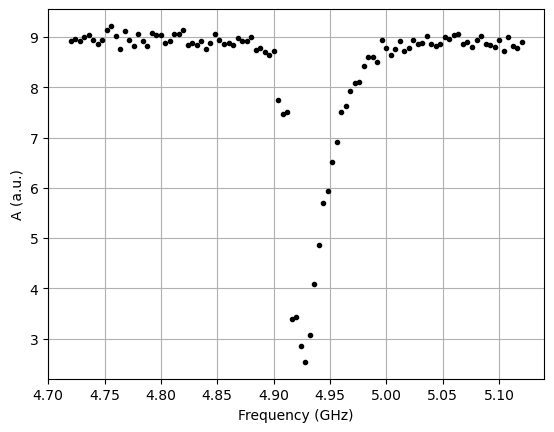

In [14]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.grid()